In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller

In [3]:
def parser(s):
    return datetime.strptime(s, '%y-%m-%d')

In [4]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [ ]:
#get data
series = pd.read_csv(r'path_of_data', parse_dates=['InvoiceDate'], index_col='InvoiceDate')
# Aggregate sales per date by summing "Taxable Amount"
series = series.groupby(series.index).sum()
series = series.asfreq(pd.infer_freq(series.index))
series = series.loc["2018-01-02":]
print(series.head())  # Display first few rows

             Taxable Amount
InvoiceDate                
2018-01-02           359.06
2018-01-03           250.46
2018-01-04           568.49
2018-01-05           395.03
2018-01-06           109.94


In [6]:
series.columns

Index(['Taxable Amount'], dtype='object')

In [7]:
from statsmodels.tsa.stattools import adfuller

def perform_adf_test(series, diff_order=1, seasonal_lag=None):
    series = series.dropna()  # Drop NaN values to avoid errors
    result = adfuller(series)

    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])

    if result[1] <= 0.05:
        print("Conclusion: The series is stationary (reject H0).")
        return
    
    print("Conclusion: The series is NOT stationary (fail to reject H0). Trying differencing...")

    # Apply first-order differencing
    differenced_series = series.diff(diff_order).dropna()
    print(f"\nPerforming ADF test after {diff_order}-order differencing:\n")
    result = adfuller(differenced_series)

    print("ADF Statistic after first-order differencing:", result[0])
    print("p-value after first-order differencing:", result[1])

    if result[1] <= 0.05:
        print("Conclusion: The series is stationary after first-order differencing (reject H0).")
        return
    
    # Apply seasonal differencing if needed
    if seasonal_lag:
        seasonally_differenced_series = series.diff(seasonal_lag).dropna()
        print(f"\nPerforming ADF test after seasonal differencing (lag={seasonal_lag}):\n")
        
        result = adfuller(seasonally_differenced_series)
        print("ADF Statistic after seasonal differencing:", result[0])
        print("p-value after first-order differencing: {:.6f}".format(result[1]))

        if result[1] <= 0.05:
            print("Conclusion: The series is stationary after seasonal differencing (reject H0).")
        else:
            print("The series is still NOT stationary after seasonal differencing.")

# Example usage:
seasonal_lag = 12
perform_adf_test(series, seasonal_lag=seasonal_lag)

ADF Statistic: -4.552128070447732
p-value: 0.0001581191400160509
Critical Values: {'1%': np.float64(-3.432918025717116), '5%': np.float64(-2.862674549708125), '10%': np.float64(-2.567373963123101)}
Conclusion: The series is stationary (reject H0).


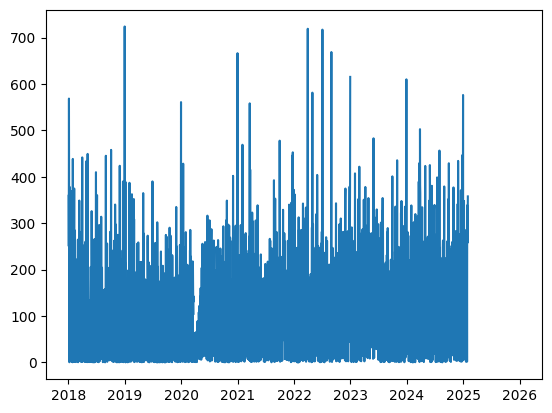

In [8]:
plt.plot(series)

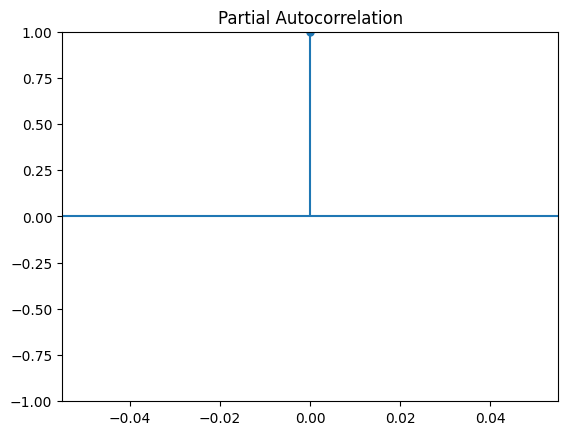

In [9]:
plot_pacf(series, lags=10)
plt.show()

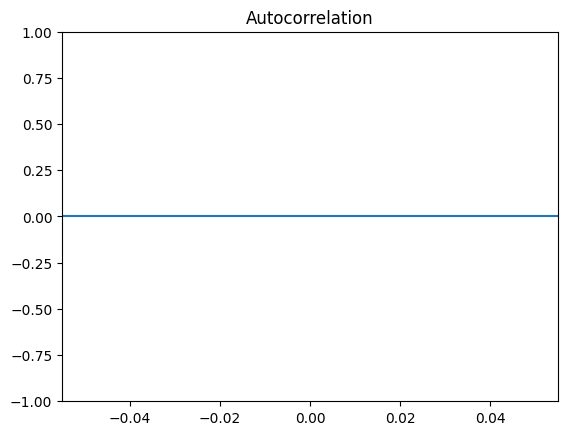

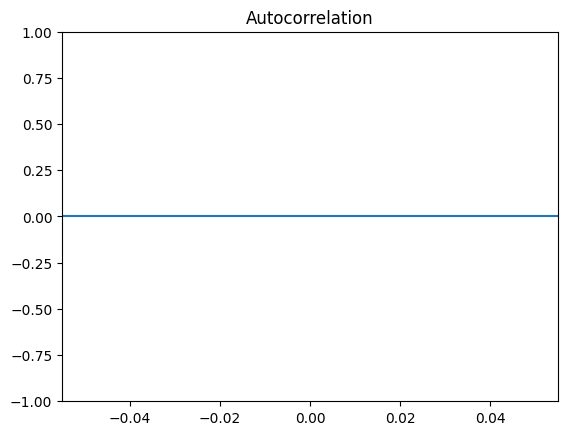

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series, lags=10)

C:\Users\A521366\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\A521366\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\A521366\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\A521366\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated freq

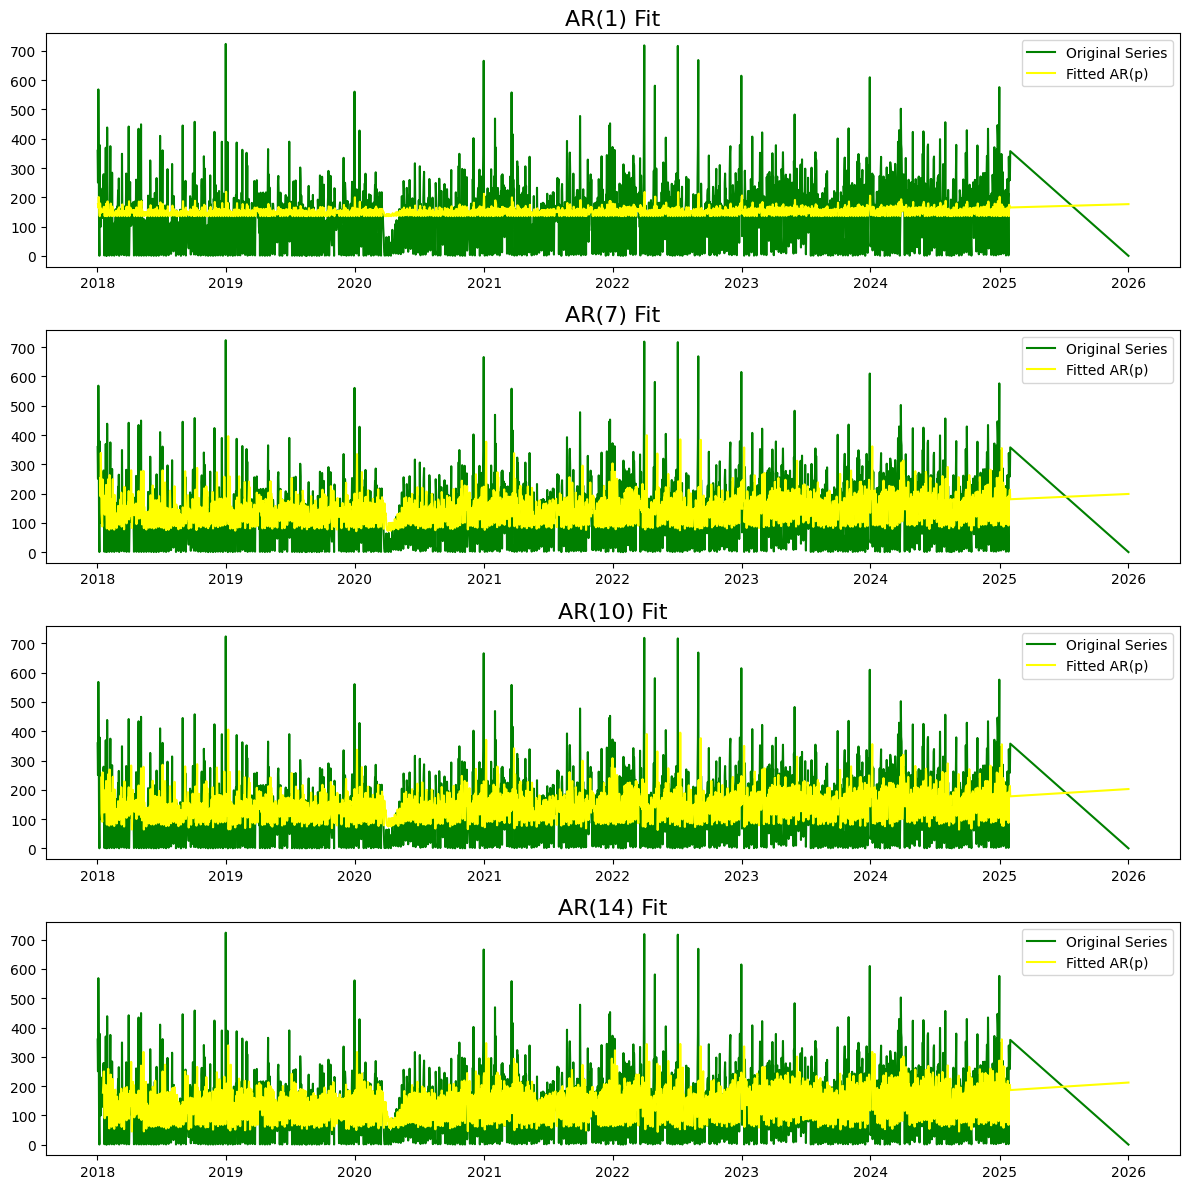

In [11]:
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

# Handle missing data: drop NaN or inf values
series = series.replace([float('inf'), -float('inf')], float('nan'))  # Replace inf with NaN
series = series.dropna()  # Remove NaN values

# Set the figure size
plt.figure(figsize=(12, 12))

ar_orders = [1, 7, 10, 14]
fitted_model_dict = {}

for idx, ar_order in enumerate(ar_orders):
    # Create AR(p) model
    ar_model = AutoReg(series, lags=ar_order)  # AR(p) model
    ar_model_fit = ar_model.fit()  # Fit the model
    fitted_model_dict[ar_order] = ar_model_fit
    
    # Plot the original series and fitted values
    plt.subplot(4, 1, idx + 1)
    plt.plot(series, label='Original Series', color='green')
    plt.plot(ar_model_fit.fittedvalues, label='Fitted AR(p)', color='yellow')
    plt.title(f'AR({ar_order}) Fit', fontsize=16)
    plt.legend()

# Adjust the layout for better visibility
plt.tight_layout()
plt.show()

In [12]:
#AIC comparison
for ar_order in ar_orders:
    print('AIC for AR(%s): %s'%(ar_order, fitted_model_dict[ar_order].aic))

AIC for AR(1): 30882.70715389084
AIC for AR(7): 30233.597798288072
AIC for AR(10): 30189.531130060146
AIC for AR(14): 29984.370769953002


In [13]:
#BIC comparison
for ar_order in ar_orders:
    print('BIC for AR(%s): %s'%(ar_order, fitted_model_dict[ar_order].bic))

BIC for AR(1): 30900.269133152513
BIC for AR(7): 30286.262748889076
BIC for AR(10): 30259.7370482306
BIC for AR(14): 30077.953709574827


In [20]:
from statsmodels.tsa.arima.model import ARIMA

# Fit AR(10) model
model_ar10 = ARIMA(series, order=(10, 0, 0))  # p=10 for AR model, d=0 (no differencing), q=0 (no MA)
result_ar10 = model_ar10.fit()

# Print model summary
print(result_ar10.summary())


C:\Users\A521366\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\A521366\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\A521366\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         Taxable Amount   No. Observations:                 2545
Model:                ARIMA(10, 0, 0)   Log Likelihood              -14964.458
Date:                Thu, 24 Apr 2025   AIC                          29952.917
Time:                        16:42:14   BIC                          30023.019
Sample:                             0   HQIC                         29978.344
                               - 2545                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.9429      4.342     35.225      0.000     144.433     161.453
ar.L1          0.1202      0.017      7.236      0.000       0.088       0.153
ar.L2          0.0333      0.020      1.691      0.0

In [21]:
from statsmodels.tsa.arima.model import ARIMA

# Fit AR(10) model
model_ar10 = ARIMA(series, order=(7, 0, 0))  # p=10 for AR model, d=0 (no differencing), q=0 (no MA)
result_ar10 = model_ar10.fit()

# Print model summary
print(result_ar10.summary())

C:\Users\A521366\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\A521366\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\A521366\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         Taxable Amount   No. Observations:                 2545
Model:                 ARIMA(7, 0, 0)   Log Likelihood              -14968.038
Date:                Thu, 24 Apr 2025   AIC                          29954.075
Time:                        16:42:17   BIC                          30006.652
Sample:                             0   HQIC                         29973.146
                               - 2545                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.9488      4.600     33.247      0.000     143.932     161.965
ar.L1          0.0976      0.015      6.553      0.000       0.068       0.127
ar.L2          0.0292      0.017      1.743      0.0

Both AR(7) and AR(10) are giving almost same AIC and BIC

AR(10) is fitting the dataset better

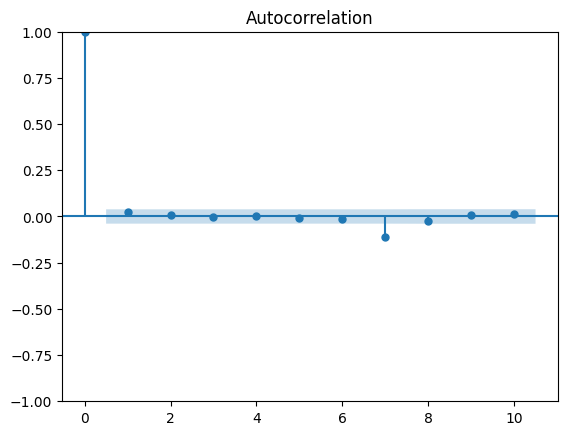

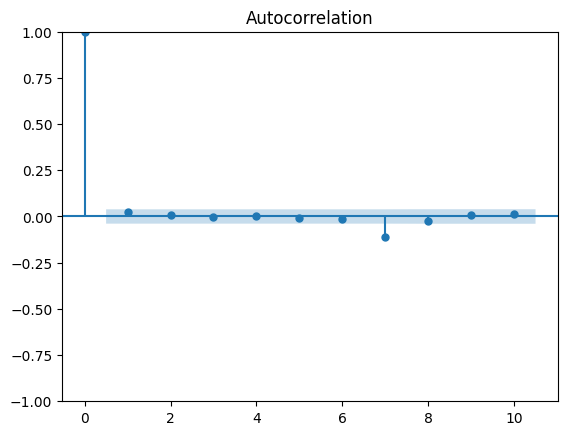

In [22]:
from statsmodels.graphics.tsaplots import plot_acf

# Check residuals for autocorrelation
plot_acf(result_ar10.resid, lags=10)


In [27]:
# Subset the series to include only data up to 2023
series_train = series.loc['2018-01-01': series.index.max()]

# Verify the data subset
print(series_train.head())
print("Hello World")
print(series_train.tail()) 

             Taxable Amount
InvoiceDate                
2018-01-02           359.06
2018-01-03           250.46
2018-01-04           568.49
2018-01-05           395.03
2018-01-06           109.94
Hello World
             Taxable Amount
InvoiceDate                
2025-12-28              NaN
2025-12-29              NaN
2025-12-30              NaN
2025-12-31              NaN
2026-01-01              0.0


In [16]:
# Subset the data to include only 2018 to 2023
series_train = series.loc['2018-01-01':'2024-12-31']

# Resample the data to monthly frequency and sum up the 'Taxable Amount' for each month
monthly_series = series_train.resample('M').sum()

# Verify the result
print(monthly_series.head())
print(monthly_series.tail())

             Taxable Amount
InvoiceDate                
2018-01-31          5539.31
2018-02-28          3320.86
2018-03-31          4662.23
2018-04-30          3945.54
2018-05-31          3785.87
             Taxable Amount
InvoiceDate                
2024-08-31          4799.74
2024-09-30          5008.25
2024-10-31          5375.29
2024-11-30          5943.82
2024-12-31          6700.51


C:\Users\A521366\AppData\Local\Temp\ipykernel_14720\347517188.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_series = series_train.resample('M').sum()


C:\Users\A521366\AppData\Local\Temp\ipykernel_2472\2155928741.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_series = monthly_series.resample('Y').sum()


<Figure size 1000x500 with 0 Axes>

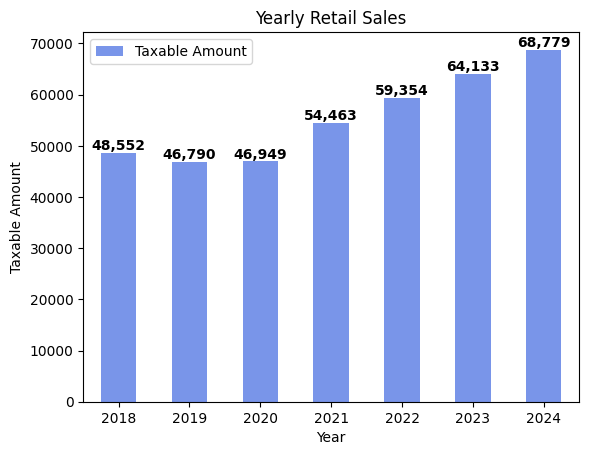

In [17]:
import matplotlib.pyplot as plt

# Group the data by year and sum up the 'Taxable Amount' for each year
yearly_series = monthly_series.resample('Y').sum()

# Create a bar plot
plt.figure(figsize=(10, 5))
bars = yearly_series.plot(kind='bar', color='royalblue', alpha=0.7)

# Customize the plot
plt.title("Yearly Retail Sales")
plt.xlabel("Year")
plt.ylabel("Taxable Amount")
plt.xticks(range(len(yearly_series)), yearly_series.index.year, rotation=0)  # Show only years

# Add data labels on top of the bars
for bar in bars.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position (center of bar)
        bar.get_height(),  # Y position (top of bar)
        f'{bar.get_height():,.0f}',  # Label (formatted with commas)
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10, 
        fontweight='bold'
    )

# Show the plot
plt.show()


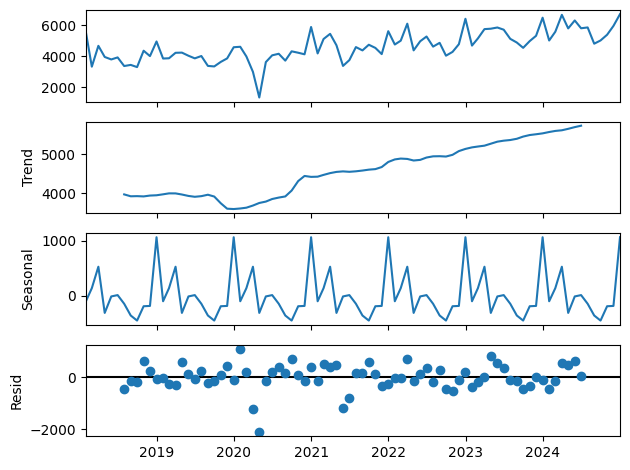

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series (assuming monthly frequency)
decomposition = seasonal_decompose(monthly_series, model='additive', period=12)

# Plot the decomposed components
# plt.figure(figsize=(12, 8))

# plt.subplot(3, 1, 1)
# plt.title("Trend of Retail Sales")
# plt.plot(decomposition.trend, label="Trend", color='royalblue')
# plt.legend(loc='upper left')

# plt.subplot(3, 1, 2)
# plt.plot(decomposition.seasonal, label="Seasonality", color='darkorange')
# plt.legend(loc='upper left')

# plt.subplot(3, 1, 3)
# plt.plot(decomposition.resid, label="Residual (Noise)", color='gray')
# plt.legend(loc='upper left')
decomposition.plot();

plt.tight_layout()
plt.show()


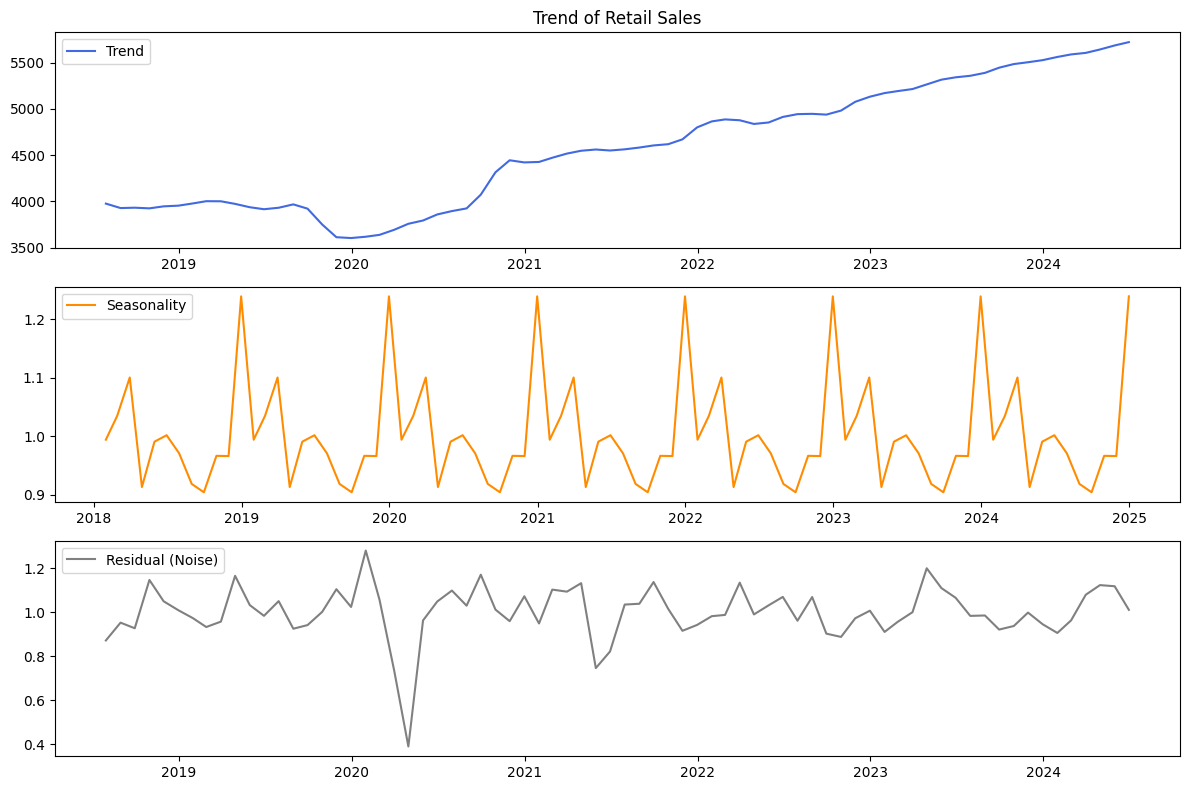

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series (assuming monthly frequency)
decomposition = seasonal_decompose(monthly_series, model='multiplicative', period=12)

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.title("Trend of Retail Sales")
plt.plot(decomposition.trend, label="Trend", color='royalblue')
plt.legend(loc='upper left')

plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal, label="Seasonality", color='darkorange')
plt.legend(loc='upper left')

plt.subplot(3, 1, 3)
plt.plot(decomposition.resid, label="Residual (Noise)", color='gray')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assume 'series' is your time series data (e.g., Taxable Amount), indexed by 'InvoiceDate'
# Set the SARIMAX model order (p, d, q) and seasonal order (P, D, Q, S)
model = SARIMAX(monthly_series,
                order=(10, 0, 0),                # (p, d, q) values
                seasonal_order=(1, 0, 0, 12),    # (P, D, Q, S) values for yearly seasonality (12 months)
                enforce_stationarity=False,      # Whether to enforce stationarity
                enforce_invertibility=False)     # Whether to enforce invertibility

# Fit the model
result = model.fit()

# Print the model summary
print(result.summary())


                                      SARIMAX Results                                      
Dep. Variable:                      Taxable Amount   No. Observations:                   84
Model:             SARIMAX(10, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -491.235
Date:                             Thu, 03 Apr 2025   AIC                           1006.470
Time:                                     09:53:38   BIC                           1031.996
Sample:                                 01-31-2018   HQIC                          1016.492
                                      - 12-31-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4486      0.130      3.460      0.001       0.195       0.703
ar.L2          0.0175      

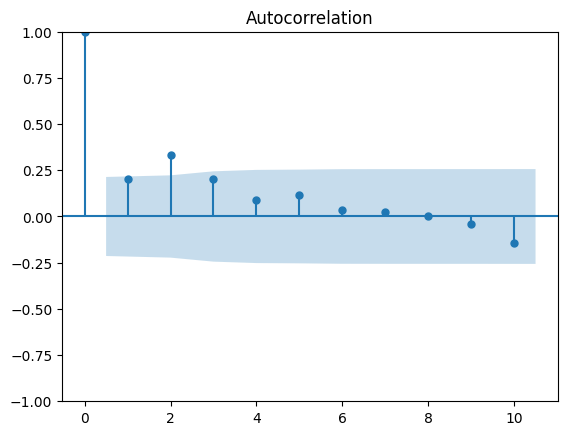

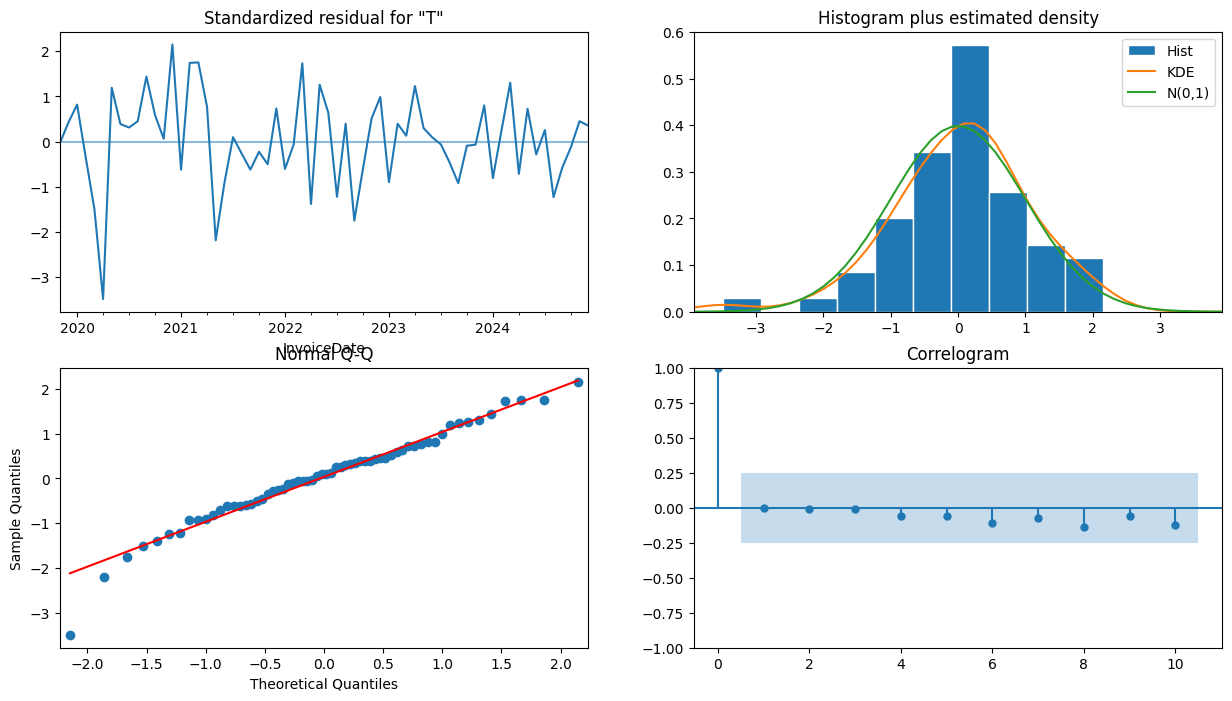

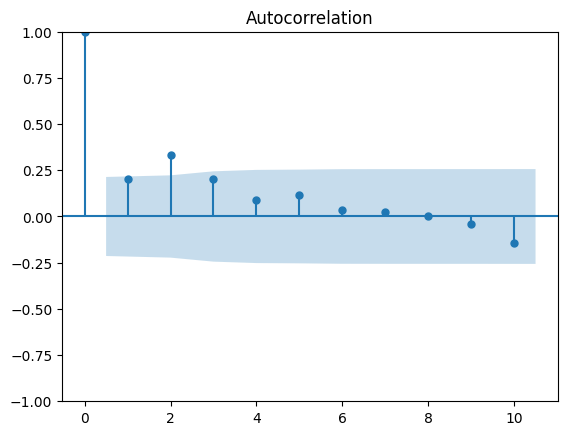

In [21]:
# Plot residuals
result.plot_diagnostics(figsize=(15, 8))

# Check the residuals ACF plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(result.resid, lags=10)

In [22]:
# Forecast for 2024 (next 12 months if monthly data)
forecast = result.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
#forecast_ci = forecast.conf_int()
# Use .apply to convert to regular numeric format
forecast_mean_formatted = forecast_mean.apply(lambda x: '{:,.0f}'.format(x))
added = forecast_mean.sum()

# Display the formatted forecast
print(forecast_mean_formatted)
print("Total sales :")
print(added)

2025-01-31    5,794
2025-02-28    5,944
2025-03-31    6,288
2025-04-30    6,148
2025-05-31    6,286
2025-06-30    6,105
2025-07-31    6,106
2025-08-31    5,722
2025-09-30    5,918
2025-10-31    6,095
2025-11-30    6,329
2025-12-31    6,595
Freq: ME, Name: predicted_mean, dtype: object
Total sales :
73330.25494934815


In [ ]:
import pandas as pd

# Load the merged CSV file
df = pd.read_csv(r'path_of_data', parse_dates=['InvoiceDate'], index_col='InvoiceDate')

# Resample the data by month and sum the "Taxable Amount" for each month
monthly_sales = df['Taxable Amount'].resample('M').sum()

# Filter the data to only include the year 2024
monthly_sales_2024 = monthly_sales.loc['2024-01-01':'2024-12-31']

monthly_sales_num = monthly_sales_2024.apply(lambda x: '{:,.0f}'.format(x))
monthly_sales_num_sum = monthly_sales_2024.sum()

# Print the monthly sales for 2024
print(monthly_sales_num)
print(monthly_sales_num_sum)

C:\Users\A521366\AppData\Local\Temp\ipykernel_2472\925475516.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['Taxable Amount'].resample('M').sum()


InvoiceDate
2024-01-31    5,006
2024-02-29    5,568
2024-03-31    6,658
2024-04-30    5,784
2024-05-31    6,296
2024-06-30    5,793
2024-07-31    5,846
2024-08-31    4,800
2024-09-30    5,008
2024-10-31    5,375
2024-11-30    5,944
2024-12-31    6,701
Name: Taxable Amount, dtype: object
68778.72


In [ ]:
import pandas as pd
from prophet import Prophet

# Load the dataset
df = pd.read_csv(r'path_of_data', 
                 parse_dates=['InvoiceDate'], index_col='InvoiceDate')

# Resample by month and sum "Taxable Amount"
monthly_sales = df['Taxable Amount'].resample('M').sum()

# Prepare Data for Prophet
prophet_df = monthly_sales.reset_index()  # Convert to DataFrame
prophet_df.columns = ['ds', 'y']  # Prophet requires 'ds' (date) and 'y' (value)

# Initialize and fit the Prophet model
model = Prophet(yearly_seasonality=True)
model.fit(prophet_df)

# Create a DataFrame for future predictions (next 12 months)
future = model.make_future_dataframe(periods=12, freq='M')

# Get the forecast
forecast = model.predict(future)

# Extract forecasted values for 2024
forecast_2024 = forecast[['ds', 'yhat']].set_index('ds').loc['2024-01-01':'2024-12-31']

# Format forecasted values
forecast_2024_formatted = forecast_2024['yhat'].apply(lambda x: '{:,.0f}'.format(x))

# Get actual sales for 2024
monthly_sales_2024 = monthly_sales.loc['2024-01-01':'2024-12-31']
monthly_sales_formatted = monthly_sales_2024.apply(lambda x: '{:,.0f}'.format(x))

# Calculate the difference
difference = abs(forecast_2024['yhat'] - monthly_sales_2024)
difference_formatted = difference.apply(lambda x: '{:,.0f}'.format(x))

# Print results
print("\nForecasted Sales for 2024:")
print(forecast_2024_formatted)

print("\nActual Sales for 2024:")
print(monthly_sales_formatted)

print("\nDifference (Absolute Error):")
print(difference_formatted)


Importing plotly failed. Interactive plots will not work.
C:\Users\A521366\AppData\Local\Temp\ipykernel_2472\1699097612.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['Taxable Amount'].resample('M').sum()
09:53:45 - cmdstanpy - INFO - Chain [1] start processing
09:53:46 - cmdstanpy - INFO - Chain [1] done processing



Forecasted Sales for 2024:
ds
2024-01-31    3,874
2024-02-29    3,823
2024-03-31    4,058
2024-04-30    2,946
2024-05-31    3,653
2024-06-30    3,666
2024-07-31    3,739
2024-08-31    3,155
2024-09-30    3,397
2024-10-31    3,394
2024-11-30    3,442
2024-12-31    4,635
Name: yhat, dtype: object

Actual Sales for 2024:
InvoiceDate
2024-01-31    5,006
2024-02-29    5,568
2024-03-31    6,658
2024-04-30    5,784
2024-05-31    6,296
2024-06-30    5,793
2024-07-31    5,846
2024-08-31    4,800
2024-09-30    5,008
2024-10-31    5,375
2024-11-30    5,944
2024-12-31    6,701
Name: Taxable Amount, dtype: object

Difference (Absolute Error):
ds
2024-01-31    1,132
2024-02-29    1,746
2024-03-31    2,600
2024-04-30    2,838
2024-05-31    2,643
2024-06-30    2,127
2024-07-31    2,107
2024-08-31    1,644
2024-09-30    1,611
2024-10-31    1,981
2024-11-30    2,502
2024-12-31    2,065
dtype: object


C:\Users\A521366\AppData\Roaming\Python\Python313\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [25]:
# Calculate the percentage difference safely (avoid division by zero)
diff_per = ((abs(forecast_2024['yhat'] - monthly_sales_2024)) / monthly_sales_2024.replace(0, 1)) * 100

# Format the percentage with two decimal places
diff_per_formatted = diff_per.apply(lambda x: '{:.2f}%'.format(x))

# Print the difference percentage
print("\nDifference Percentage:")
print(diff_per_formatted)



Difference Percentage:
ds
2024-01-31    22.61%
2024-02-29    31.35%
2024-03-31    39.05%
2024-04-30    49.07%
2024-05-31    41.97%
2024-06-30    36.72%
2024-07-31    36.05%
2024-08-31    34.26%
2024-09-30    32.17%
2024-10-31    36.85%
2024-11-30    42.09%
2024-12-31    30.82%
dtype: object


In [26]:
# Calculate accuracy percentage
accuracy_per_month = 100 - diff_per

# Format accuracy with two decimal places
accuracy_per_month_formatted = accuracy_per_month.apply(lambda x: '{:.2f}%'.format(x))

# Print accuracy per month
print("\nAccuracy per month:")
print(accuracy_per_month_formatted)



Accuracy per month:
ds
2024-01-31    77.39%
2024-02-29    68.65%
2024-03-31    60.95%
2024-04-30    50.93%
2024-05-31    58.03%
2024-06-30    63.28%
2024-07-31    63.95%
2024-08-31    65.74%
2024-09-30    67.83%
2024-10-31    63.15%
2024-11-30    57.91%
2024-12-31    69.18%
dtype: object


In [27]:
# Calculate MAPE (Mean Absolute Percentage Error)
mape = diff_per.mean()  # No need for .abs() since diff_per is already absolute

# Format and print MAPE
print(f"\nMAPE (Mean Absolute Percentage Error) for the model: {mape:.2f}%")



MAPE (Mean Absolute Percentage Error) for the model: 36.08%


In [28]:
# Calculate average monthly accuracy
monthly_accuracy_avg = accuracy_per_month.mean()

# Format and print the model accuracy
print(f"\nModel Accuracy: {monthly_accuracy_avg:.2f}%")



Model Accuracy: 63.92%


C:\Users\A521366\AppData\Local\Temp\ipykernel_2472\1707293658.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['Taxable Amount'].resample('M').sum()
C:\Users\A521366\AppData\Local\Temp\ipykernel_2472\1707293658.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_mean.index = pd.date_range(start='2024-01-01', periods=12, freq='M')  # Ensure index matches the months in 2024


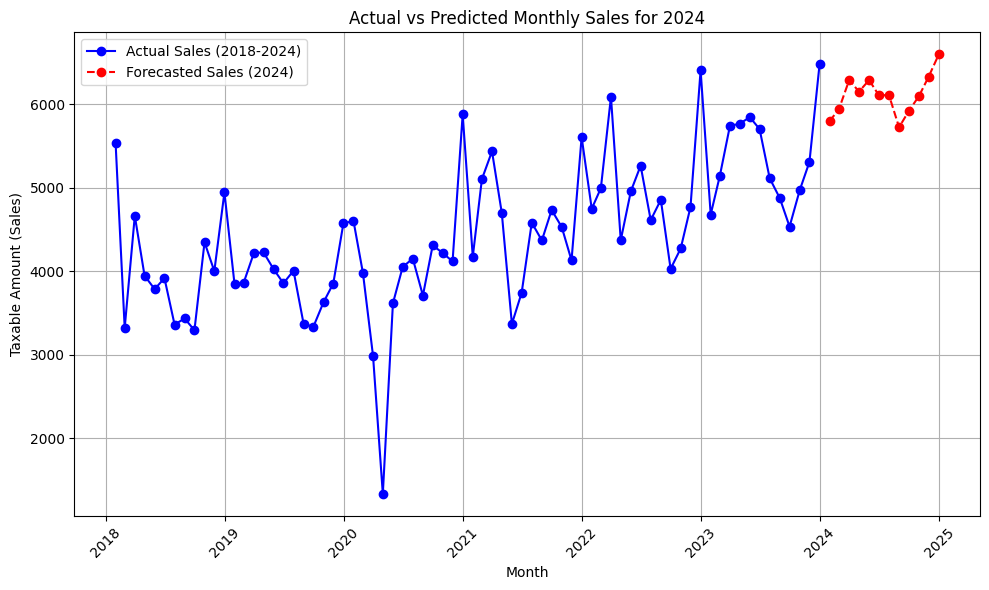

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the merged CSV file (actual data)
df = pd.read_csv(r'path_of_data', parse_dates=['InvoiceDate'], index_col='InvoiceDate')

# Resample the data by month and sum the "Taxable Amount" for each month
monthly_sales = df['Taxable Amount'].resample('M').sum()

# Filter the actual sales data for the years you are interested in (e.g., 2017 to 2024)
actual_sales = monthly_sales.loc['2018-01-01':'2023-12-31']

# Forecast for 2024 (next 12 months if monthly data)
forecast = result.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean

# Format the forecast to make it readable
forecast_mean.index = pd.date_range(start='2024-01-01', periods=12, freq='M')  # Ensure index matches the months in 2024

# Plotting
plt.figure(figsize=(10, 6))

# Plot actual sales (from 2017 to 2023)
plt.plot(actual_sales.index, actual_sales, label='Actual Sales (2018-2024)', color='blue', marker='o')

# Plot forecasted sales for 2024
plt.plot(forecast_mean.index, forecast_mean, label='Forecasted Sales (2024)', color='red', linestyle='--', marker='o')

# Adding labels and title
plt.title('Actual vs Predicted Monthly Sales for 2024')
plt.xlabel('Month')
plt.ylabel('Taxable Amount (Sales)')
plt.legend()

# Display the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Load the data
df = pd.read_csv(r'path_of_data', parse_dates=['InvoiceDate'], index_col='InvoiceDate')
                 parse_dates=['InvoiceDate'], index_col='InvoiceDate')

# Resample the data by month and sum the "Taxable Amount" for each month
monthly_sales = df['Taxable Amount'].resample('M').sum()

# Filter actual sales data (2018 to 2023)
actual_sales = monthly_sales.loc['2018-01-01':'2024-12-31']

# Fit SARIMAX Model
order = (1, 1, 1)  # You can tune p, d, q values
seasonal_order = (1, 1, 1, 12)  # Seasonal parameters for monthly data (12-month cycle)

model = sm.tsa.statespace.SARIMAX(actual_sales, order=order, seasonal_order=seasonal_order)
result = model.fit()

# Forecast for next 2 years (24 months)
forecast = result.get_forecast(steps=24)
forecast_mean = forecast.predicted_mean
forecast_se = forecast.se_mean
forecast_ci = forecast.conf_int()

# Create DataFrame for forecasted values
forecast_df = pd.DataFrame({
    'Date': pd.date_range(start='2025-01-01', periods=24, freq='M'),
    'Taxable Amount': forecast_mean.values,
    'Mean_SE': forecast_se.values,
    'Mean_CI_Lower': forecast_ci.iloc[:, 0].values,
    'Mean_CI_Upper': forecast_ci.iloc[:, 1].values
})

# Print the table
print(forecast_df)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\A521366\\OneDrive - Volvo Group\\Documents\\Sales_Forecasting\\data\\Retail.csv'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the merged CSV file (actual data)
df = pd.read_csv(r'path_of_data', parse_dates=['InvoiceDate'], index_col='InvoiceDate')

# Resample the data by month and sum the "Taxable Amount" for each month
monthly_sales = df['Taxable Amount'].resample('M').sum()

# Filter the actual sales data for the year 2024
actual_sales_2024 = monthly_sales.loc['2024-01-01':'2024-12-31']

# Forecast for 2024 (next 12 months if monthly data)
forecast = result.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean

# Format the forecast to make it readable
forecast_mean.index = pd.date_range(start='2024-01-01', periods=12, freq='M')  # Ensure index matches the months in 2024

# Plotting
plt.figure(figsize=(10, 6))

# Plot actual sales for 2024
plt.plot(actual_sales_2024.index, actual_sales_2024, label='Actual Sales (2024)', color='blue', marker='o')

# Plot forecasted sales for 2024
plt.plot(forecast_mean.index, forecast_mean, label='Forecasted Sales (2024)', color='red', marker='o')

# Adding data labels to the plot points for actual sales (2024)
for i, txt in enumerate(actual_sales_2024):
    plt.text(actual_sales_2024.index[i], txt, f'{txt:,.0f}', color='blue', fontsize=9, ha='center', va='bottom')

# Adding data labels to the plot points for forecasted sales (2024)
for i, txt in enumerate(forecast_mean):
    plt.text(forecast_mean.index[i], txt, f'{txt:,.0f}', color='red', fontsize=9, ha='center', va='bottom')

# Adding labels and title
plt.title('Actual vs Predicted Monthly Sales for 2024')
plt.xlabel('Month')
plt.ylabel('Taxable Amount (Sales)')
plt.legend()

# Display the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(r'path_of_data', 
                 parse_dates=['InvoiceDate'], index_col='InvoiceDate')

# Resample the data by month and sum the "Taxable Amount" for each month
monthly_sales = df['Taxable Amount'].resample('M').sum()

# Split the data: Actual sales up to 2023, Forecast for 2024 & 2025
actual_sales = monthly_sales.loc[:'2023-12-31']

# Forecast for 24 months (2024 & 2025)
forecast = result.get_forecast(steps=24)
forecast_mean = forecast.predicted_mean
forecast_mean.index = pd.date_range(start='2024-01-01', periods=24, freq='M')  # Ensure index continuity

# Plotting
plt.figure(figsize=(12, 6))

# Plot actual sales (till 2023)
plt.plot(actual_sales.index, actual_sales, label='Actual Sales (Till 2023)', color='blue', marker='o')

# Plot forecasted sales (2024 & 2025)
plt.plot(forecast_mean.index, forecast_mean, label='Forecasted Sales (2024-2025)', color='red', linestyle='--', marker='x')

# Data labels for actual sales (optional, remove if too cluttered)
for i, txt in enumerate(actual_sales[-12:]):  # Show last 12 months of labels to avoid clutter
    plt.text(actual_sales.index[-12+i], txt, f'{txt:,.0f}', color='blue', fontsize=8, ha='center', va='bottom')

# Data labels for forecasted sales
for i, txt in enumerate(forecast_mean):
    if i % 3 == 0:  # Show labels every 3 months to avoid clutter
        plt.text(forecast_mean.index[i], txt, f'{txt:,.0f}', color='red', fontsize=8, ha='center', va='bottom')

# Labels, title, and legend
plt.title('Actual vs Forecasted Sales (Month-wise)')
plt.xlabel('Year-Month')
plt.ylabel('Taxable Amount (Sales)')
plt.legend()
plt.grid(True)

# Adjust x-axis labels
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(r'path_of_data', 
                 parse_dates=['InvoiceDate'], index_col='InvoiceDate')

# Resample the data by month and sum the "Taxable Amount" for each month
monthly_sales = df['Taxable Amount'].resample('M').sum()

monthly_sales = monthly_sales / 1e7

# Split the data: Actual sales up to 2023, Forecast for 2024 & 2025
actual_sales = monthly_sales.loc[:'2023-12-31']

# Forecast for 24 months (2024 & 2025)
forecast = result.get_forecast(steps=24)
forecast_mean = forecast.predicted_mean

forecast_mean = forecast_mean / 1e7
forecast_mean.index = pd.date_range(start='2024-01-01', periods=24, freq='M')  # Ensure index continuity

# Plotting
plt.figure(figsize=(12, 6))

# Plot actual sales (till 2023) - No markers, smooth line
plt.plot(actual_sales.index, actual_sales, label='Actual Sales (Till 2023)', color='blue', linewidth=2)

# Plot forecasted sales (2024 & 2025) - No markers, dashed line
plt.plot(forecast_mean.index, forecast_mean, label='Forecasted Sales (2024-2025)', color='red', linewidth=2)

# Labels, title, and legend
plt.title('Actual vs Forecasted Sales (Month-wise)', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Taxable Amount (Sales)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.6)

# Adjust x-axis labels
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(r'path_of_data', 
                 parse_dates=['InvoiceDate'], index_col='InvoiceDate')

# Resample the data by month and sum the "Taxable Amount" for each month
monthly_sales = df['Taxable Amount'].resample('M').sum()

monthly_sales = monthly_sales / 1e7

# Split the data: Actual sales up to 2023, Forecast for 2024 & 2025
actual_sales = monthly_sales.loc['2018-01-01':'2023-12-31']

# Forecast for 24 months (2024 & 2025)
forecast = result.get_forecast(steps=24)
forecast_mean = forecast.predicted_mean

forecast_mean = forecast_mean / 1e7
forecast_mean.index = pd.date_range(start='2024-01-01', periods=24, freq='M')  # Ensure index continuity

# Plotting
plt.figure(figsize=(12, 6))

# Plot actual sales (till 2023) - No markers, smooth line
plt.plot(actual_sales.index, actual_sales, label='Actual Sales (Till 2023)', color='blue', linewidth=1, marker = 'o')

# Plot forecasted sales (2024 & 2025) - No markers, dashed line
plt.plot(forecast_mean.index, forecast_mean, label='Forecasted Sales (2024-2025)', color='red', linewidth=1, marker = 'o')

# Add data labels for actual sales (showing last 12 months only)
for i, txt in enumerate(actual_sales):  
    plt.text(actual_sales.index[-12+i], txt, f'{txt:,.1f}', color='blue', fontsize=8, ha='center', va='bottom')

# Add data labels for forecasted sales (show every 3 months)
for i, txt in enumerate(forecast_mean):
    if i % 3 == 0:  
        plt.text(forecast_mean.index[i], txt, f'{txt:,.1f}', color='red', fontsize=8, ha='center', va='bottom')


# Labels, title, and legend
plt.title('Actual vs Forecasted Sales (Month-wise)', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Taxable Amount (Sales)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.6)

# Adjust x-axis labels
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()